In [1]:
import numpy as np
import pandas as pd
import random
import time
import scipy as sp
from scipy.sparse.linalg import cg
from sklearn.metrics.pairwise import rbf_kernel

In [1]:
from data_datasets import higgs, susy, cod_rna
N =10000
seed=123
data = "susy"
# data = "higgs"
# data = "cod_rna"
####################

if data == "higgs":
    X_train, X_test, y_train, y_test = higgs(N, seed)
elif data == "susy":
    X_train, X_test, y_train, y_test = susy(N, seed)
elif data == "cod_rna":
    X_train, X_test, y_train, y_test = cod_rna(N, seed)

print("\nDataset:", data)
print("--------\nShape train data:", X_train.shape)
print("Shape test data:", X_test.shape)


Dataset: susy
--------
Shape train data: (10000, 18)
Shape test data: (10000, 18)


In [ ]:
def nystrom(K, rank):
    N = K.shape[0]
    Omega = np.random.randn(N, rank)
    Y = K@Omega  # matvec
    eps = np.finfo(float).eps
    shift = np.linalg.norm(Y, "fro")*eps
    Y_shift = Y+shift*Omega
    C = np.linalg.cholesky(Omega.T@Y_shift)
    B = Y_shift @ np.linalg.inv(C)

    U, D, VT = np.linalg.svd(B, full_matrices=False)
    Sigma = np.diag(D)
    Lamda = np.maximum(0, Sigma@Sigma-shift*np.eye(rank))

    return U, Lamda

In [3]:
from kernels import GaussianKernel_mtx
mu = 4
N, d = X_train.shape
I = np.eye(N)
K = GaussianKernel_mtx(np.asarray(X_train), np.asarray(X_train), bandwidth=.1)
K_reg=K+mu*I

In [7]:
from utils import CG

result = CG(A=K_reg, b=y_train, tol=1e-16)

In [8]:
result

(array([ 0.2,  0.2,  0.2, ...,  0.2,  0.2, -0.2]),
 array([1.00000000e+02, 2.03924141e-04, 6.68241464e-09, 3.24632497e-14]))

In [35]:
residuals = []
b = y_train


def callback(x): return residuals.append(
    np.linalg.norm(K_reg @ x - b))
# / np.linalg.norm(b)


alpha, info = cg(K_reg, b, callback=callback, tol=1e-16)
len(residuals)
residuals

[0.00020392414106080924,
 6.6824146968780456e-09,
 3.446540709017479e-14,
 1.0997374119838626e-14,
 3.635026844804856e-15]

In [36]:
from utils import diag_inv
from low_rank_methods import nystrom
rank = 20
i = np.eye(rank)
Nys = nystrom(K, rank)
U = Nys[0]
D = Nys[1]

residuals_pre = []
b = y_train
B = diag_inv(D+mu)
lambda_l = D[-1, -1]

P_nys = U@(D+mu)@U.T/(lambda_l+mu)+I-U@U.T
P_nys_inv = (lambda_l+mu)*U@B@U.T+I-U@U.T


def callback(x): return residuals_pre.append(
    np.linalg.norm(K_reg @ x - b) )
# / np.linalg.norm(b)


alpha_pre, info = cg(K_reg, b, M=P_nys, callback=callback, tol=1e-3)
len(residuals_pre)

3

In [27]:
import numpy as np
import scipy.linalg as la


def CG(A, b, P=None, matvec=None, tol=1e-5, x0=None, max_iter=None):
    """
    Conjugate Gradient Method for solving Ax = b
    :param A: matrix
    :param b: vector
    :param tol: tolerance (default: 1e-5)
    :param x0: initial guess (default: Zero vector)
    :param max_iter: Maximum number of iterations (default: Dimension of A)
    :param P: The Preconditioner (default: None for CG)
    :param matvec: Function to perform matrix-vector multiplication (default: None)
    :return: x, residuals
    """

    N = len(b)
    residuals = []
    dot = np.dot

    if max_iter is None:
        max_iter = N

    if matvec is None:
        def matvec(M, u):
            return M @ u

    x = np.zeros(N) if x0 is None else x0
    r = b - matvec(A, x)
    p = r.copy()

    if P is not None:
        z = np.linalg.solve(P , r)
        p = z.copy()
    else:
        z = r

    i = 0
    while i < max_iter and la.norm(r) > tol:
        residuals.append(np.linalg.norm(r))

        if la.norm(r) < tol:
            break

        v = matvec(A, p)

        if P is None:
            alpha = dot(r, r) / dot(p, v)
        else:
            alpha = dot(r, z) / dot(p, v)

        x = x + alpha * p
        r_new = r - alpha * v

        if P is None:
            beta = dot(r_new, r_new) / dot(r, r)
        else:
            z_new = np.linalg.solve(P , r_new)
            beta = dot(z_new, r_new) / dot(z, r)
            z = z_new

        p = z + beta * p if P is not None else r_new + beta * p
        r = r_new
        i += 1

    return x, np.array(residuals)

In [33]:
results = CG(A=K_reg, b=y_train, P=None, matvec=None, tol=1e-5, x0=None, max_iter=None)

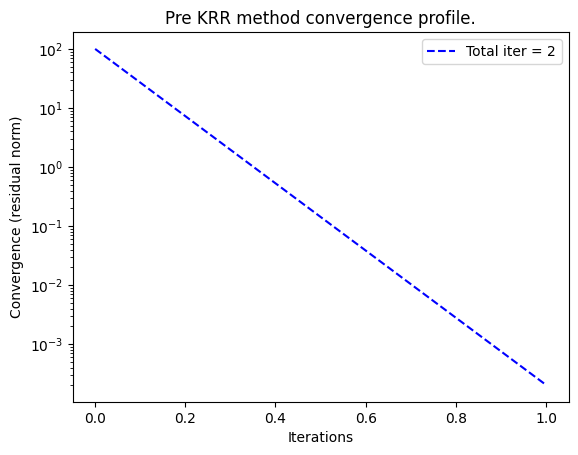

In [34]:
# """Show plot with convergence profile - normalised residual vector vs iteration."""
import matplotlib.pyplot as plt
plt.title('Pre KRR method convergence profile.')
plt.ylabel('Convergence (residual norm)')
plt.xlabel('Iterations')

m_res = results[1]
plt.semilogy(range(len(m_res)), m_res, 'b--')

plt.legend(['Total iter = ' + str(len(m_res))])
# plt.show()

In [29]:
from utils import diag_inv
from low_rank_methods import nystrom
rank = 20
i = np.eye(rank)
Nys = nystrom(K, rank)
U = Nys[0]
D = Nys[1]

residuals_pre = []
b = y_train
B = diag_inv(D+mu)
lambda_l = D[-1, -1]

P_nys = U@(D+mu)@U.T/(lambda_l+mu)+I-U@U.T
P_nys_inv = (lambda_l+mu)*U@B@U.T+I-U@U.T

P_nys_inv.shape

(10000, 10000)

In [30]:
results_pre = CG(A=K_reg, b=y_train, P=P_nys, matvec=None, tol=1e-5, x0=None, max_iter=None)

In [23]:
results_pre[0].shape, alpha_pre.shape

((10000,), (10000,))

In [21]:
np.round(results_pre[0]-alpha_pre).all()==0

True

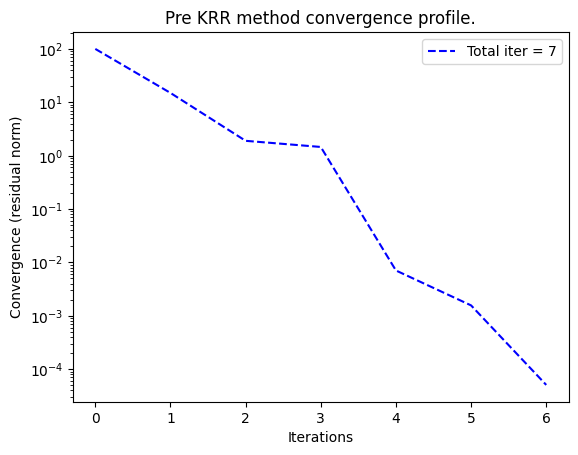

In [32]:
# """Show plot with convergence profile - normalised residual vector vs iteration."""
import matplotlib.pyplot as plt
plt.title('Pre KRR method convergence profile.')
plt.ylabel('Convergence (residual norm)')
plt.xlabel('Iterations')

m_res = results_pre[1]
plt.semilogy(range(len(m_res)), m_res, 'b--')

plt.legend(['Total iter = ' + str(len(m_res))])
# plt.show()

In [31]:
results_pre[1]

array([1.00000000e+02, 1.49657737e+01, 1.89539843e+00, 1.45431553e+00,
       7.04083869e-03, 1.56009882e-03, 5.04307948e-05])

In [ ]:
import numpy as np


class RandomFourierFeatures:
    def __init__(self, d, N, sigma):
        self.d = d
        self.N = N
        self.sigma = sigma
        self.W = np.random.normal(scale=1/sigma, size=(rank, d))
        self.b = np.random.uniform(0, 2*np.pi, size=rank)

    def transform(self, X):
        projection = X @ self.W + self.b
        return np.sqrt(2/self.N) * np.cos(projection)

# W = np.random.normal(loc=0, scale=1, size=(self.rff_dim, D))
# b = np.random.uniform(0, 2*np.pi, size=self.rff_dim)

# Example usage
X = np.random.randn(100, 5)  # 100 samples, 5-dimensional input
rff = RandomFourierFeatures(N=100, d=5, sigma=1.0)
Z = rff.transform(X)

In [ ]:
def rff(X, srff_dim, sigma):
    """Return random Fourier features based on data X, as well as random
    variables W and b.
    """
    N, D = X.shape

    W = np.random.normal(loc=0, scale=1, size=(srff_dim, D))
    b = np.random.uniform(0, 2*np.pi, size=srff_dim)

    B    = np.repeat(b[:, np.newaxis], N, axis=1)
    norm = 1./ np.sqrt(srff_dim)
    Z    = norm * np.sqrt(2) * np.cos(sigma * W @ X.T + B)
    return Z.T, W, b

In [ ]:
X = np.random.randn(100, 50)
Z, W, b = rff(X, srff_dim=10, sigma=1.)
Z.shape, W.shape

In [ ]:
from sklearn.base import BaseEstimator
from sklearn.exceptions import NotFittedError
from scipy.stats import cauchy, laplace
import numpy as np


class RFF(BaseEstimator):
    def __init__(self, gamma=1, D=50, metric="rbf"):
        self.gamma = gamma
        self.metric = metric
        # Dimensionality D (number of MonteCarlo samples)
        self.D = D
        self.fitted = False

    def fit(self, X, y=None):
        """ Generates MonteCarlo random samples """
        d = X.shape[1]
        # Generate D iid samples from p(w)
        if self.metric == "rbf":
            self.w = np.sqrt(2*self.gamma)*np.random.normal(size=(self.D, d))
        elif self.metric == "laplace":
            self.w = cauchy.rvs(scale=self.gamma, size=(self.D, d))

        # Generate D iid samples from Uniform(0,2*pi)
        self.u = 2*np.pi*np.random.rand(self.D)
        self.fitted = True
        return self

    def transform(self, X):
        """ Transforms the data X (n_samples, n_features) to the new map space Z(X) (n_samples, n_components)"""
        if not self.fitted:
            raise NotFittedError(
                "RBF_MonteCarlo must be fitted beform computing the feature map Z")
        # Compute feature map Z(x):
        Z = np.sqrt(2/self.D)*np.cos((X.dot(self.w.T) + self.u[np.newaxis, :]))
        return Z

    def compute_kernel(self, X):
        """ Computes the approximated kernel matrix K """
        if not self.fitted:
            raise NotFittedError(
                "RBF_MonteCarlo must be fitted beform computing the kernel matrix")
        Z = self.transform(X)
        K = Z.dot(Z.T)
        return K

In [ ]:
def rff3(X, D, sigma):
    """Return random Fourier features based on data X, as well as random
    variables W and b.
    """
    N, d = X.shape
    W = np.sqrt(2*sigma)*np.random.normal(size=(D, d))
    b = 2*np.pi*np.random.rand(D)
    Z = np.sqrt(2/D)*np.cos((X.dot(W.T) + b[np.newaxis, :]))
    return Z, W, b

In [ ]:
X = np.random.randn(100, 50)
Z, W, b = rff3(X, D=10, sigma=1.)
Z.shape, W.shape, b.shape

In [3]:
import numpy as np

# Assuming S is a 2D square matrix and mu is a scalar
mu = 1  # Example value for mu
S = np.array([[1, 0], [0, 2]])  # Example 2D square matrix

d = 1 / (np.diag(S)**2 + mu) - 1/mu
d

array([-0.5, -0.8])